# Universal Approximation Theorem: From Function Spaces to Neural Networks

## Mathematical Foundations: Function Spaces

To understand what neural networks can approximate, we need a mathematical framework for measuring "closeness" between functions. This leads us to function spaces.

### Banach Spaces: The Setting for Approximation

A **Banach space** is a complete normed vector space. For our purposes:

1. **Vector Space of Functions**: We can add functions and multiply by scalars
   - $(f + g)(x) = f(x) + g(x)$
   - $(\alpha f)(x) = \alpha \cdot f(x)$

2. **Norm**: A way to measure the "size" of a function
   - $L^\infty$ norm (supremum): $\|f\|_\infty = \sup_{x \in [a,b]} |f(x)|$
   - $L^2$ norm: $\|f\|_2 = \left(\int_a^b |f(x)|^2 dx\right)^{1/2}$
   - $L^1$ norm: $\|f\|_1 = \int_a^b |f(x)| dx$

3. **Completeness**: Cauchy sequences converge to a limit in the space

### Hilbert Spaces: Adding Geometry

A **Hilbert space** is a Banach space with an inner product:

$$\langle f, g \rangle = \int_a^b f(x)g(x) dx$$

This enables:
- **Orthogonality**: $\langle f, g \rangle = 0$ means $f$ and $g$ are orthogonal
- **Projections**: Finding the best approximation in a subspace
- **Basis expansions**: $f = \sum_{i=1}^\infty c_i \phi_i$ where $\{\phi_i\}$ is an orthonormal basis

<>:44: SyntaxWarning: invalid escape sequence '\|'
<>:44: SyntaxWarning: invalid escape sequence '\|'
<>:44: SyntaxWarning: invalid escape sequence '\|'
<>:44: SyntaxWarning: invalid escape sequence '\|'
/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_89370/598079796.py:44: SyntaxWarning: invalid escape sequence '\|'
  axes[i].text(0.5, 0.05, f'$\|f - f_{{approx}}\|_\infty$ = {error:.3f}',
/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_89370/598079796.py:44: SyntaxWarning: invalid escape sequence '\|'
  axes[i].text(0.5, 0.05, f'$\|f - f_{{approx}}\|_\infty$ = {error:.3f}',


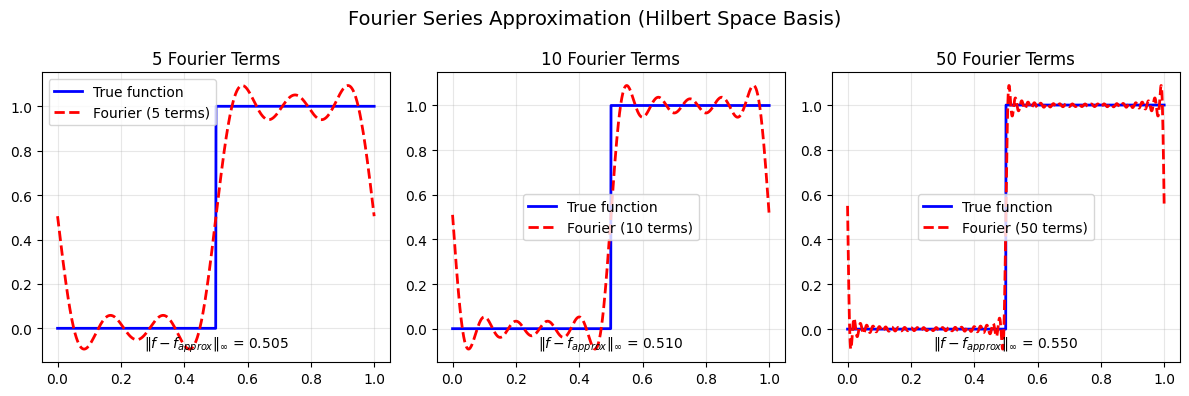

In [15]:
# Fourier series as an example of basis expansion in Hilbert space
def fourier_approximation(f: Callable, n_terms: int, x_points: np.ndarray):
    """Approximate function using Fourier series."""
    # Compute Fourier coefficients
    a0 = 2 * np.mean([f(x) for x in np.linspace(0, 1, 1000)])
    
    approx = np.ones_like(x_points) * a0 / 2
    
    for n in range(1, n_terms + 1):
        # Compute an and bn coefficients
        x_integration = np.linspace(0, 1, 1000)
        y_integration = [f(x) for x in x_integration]
        
        an = 2 * np.mean([y * np.cos(2*np.pi*n*x) 
                         for x, y in zip(x_integration, y_integration)])
        bn = 2 * np.mean([y * np.sin(2*np.pi*n*x) 
                         for x, y in zip(x_integration, y_integration)])
        
        approx += an * np.cos(2*np.pi*n*x_points) + bn * np.sin(2*np.pi*n*x_points)
    
    return approx

# Visualize Fourier approximation
def step_function(x):
    return np.where(x < 0.5, 0, 1)

x = np.linspace(0, 1, 1000)
y_true = step_function(x)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
terms = [5, 10, 50]

for i, n_terms in enumerate(terms):
    y_approx = fourier_approximation(step_function, n_terms, x)
    
    axes[i].plot(x, y_true, 'b-', linewidth=2, label='True function')
    axes[i].plot(x, y_approx, 'r--', linewidth=2, label=f'Fourier ({n_terms} terms)')
    axes[i].set_title(f'{n_terms} Fourier Terms')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Compute approximation error
    error = np.max(np.abs(y_true - y_approx))
    axes[i].text(0.5, 0.05, f'$\|f - f_{{approx}}\|_\infty$ = {error:.3f}',
                transform=axes[i].transAxes, ha='center')

plt.suptitle('Fourier Series Approximation (Hilbert Space Basis)', fontsize=14)
plt.tight_layout()
plt.show()

### Density: The Key Concept

A subset $S$ is **dense** in a space $X$ if:

$$\forall f \in X, \forall \epsilon > 0, \exists g \in S : \|f - g\| < \epsilon$$

In words: Every function in $X$ can be approximated arbitrarily well by functions from $S$.

**The Universal Approximation Theorem states**: Neural networks form a dense subset in $C([a,b])$ (continuous functions on $[a,b]$).

## Universal Approximation Theorem: Two Proofs

### 1. Constructive Proof with ReLU

The ReLU activation $\text{ReLU}(x) = \max(0, x)$ allows us to build approximations constructively.

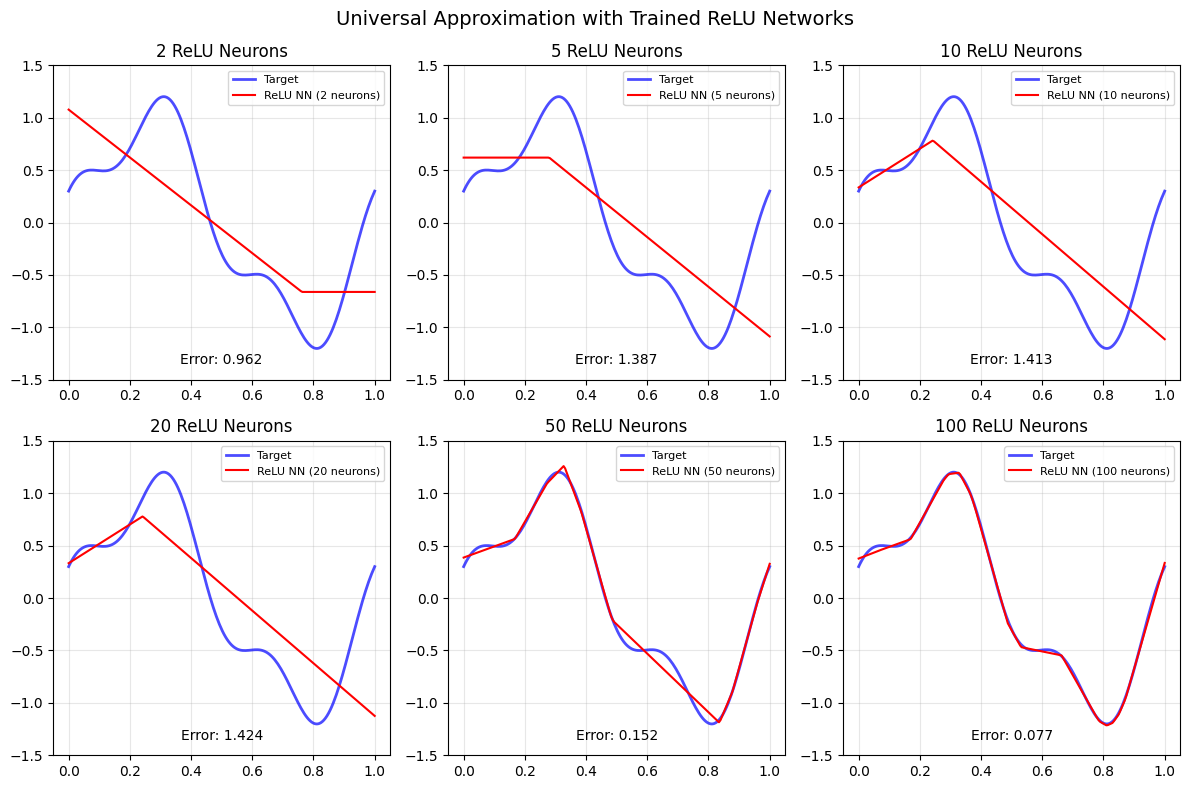

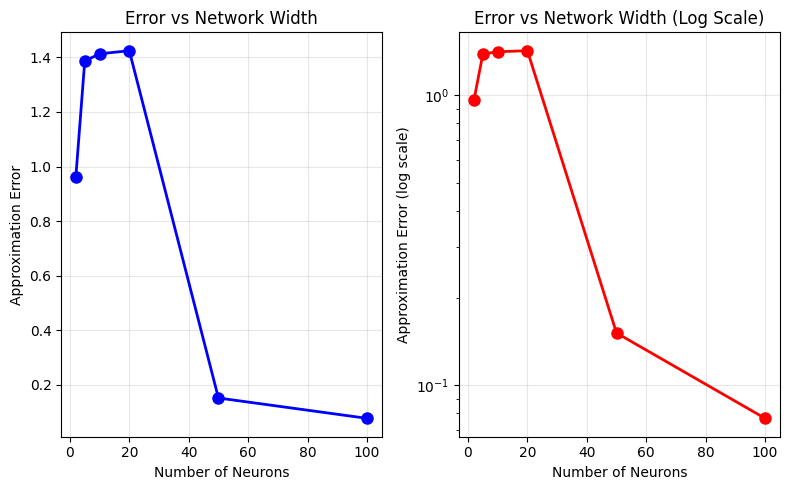

Error reduction: 0.9619 (2 neurons) → 0.0770 (100 neurons)
Improvement factor: 12.5x

As the number of ReLU neurons increases, the approximation error decreases,
demonstrating the Universal Approximation Theorem in practice.


In [16]:
# Train ReLU networks with different numbers of neurons
import torch
import torch.nn as nn
import torch.optim as optim

class ReLUNet(nn.Module):
    def __init__(self, n_neurons):
        super().__init__()
        self.fc1 = nn.Linear(1, n_neurons)
        self.fc2 = nn.Linear(n_neurons, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_relu_network(target_func, n_neurons, epochs=3000, lr=0.01):
    """Train a ReLU network to approximate a target function."""
    # Generate training data
    x_train = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_train = torch.tensor([target_func(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)
    
    # Create model
    model = ReLUNet(n_neurons)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Train
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    return model, loss.item()

# Target function to approximate
target_func = lambda x: np.sin(2 * np.pi * x) + 0.3 * np.cos(6 * np.pi * x)

# Train networks with different numbers of neurons
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
neuron_counts = [2, 5, 10, 20, 50, 100]

x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
x_test_np = x_test.numpy().flatten()
y_true = np.array([target_func(x) for x in x_test_np])

errors = []
for idx, n_neurons in enumerate(neuron_counts):
    row = idx // 3
    col = idx % 3
    
    # Train network
    model, final_loss = train_relu_network(target_func, n_neurons, epochs=5000)
    
    # Get predictions
    with torch.no_grad():
        y_pred = model(x_test).numpy().flatten()
    
    # Plot
    axes[row, col].plot(x_test_np, y_true, 'b-', linewidth=2, label='Target', alpha=0.7)
    axes[row, col].plot(x_test_np, y_pred, 'r-', linewidth=1.5, 
                       label=f'ReLU NN ({n_neurons} neurons)')
    axes[row, col].set_title(f'{n_neurons} ReLU Neurons')
    axes[row, col].legend(loc='upper right', fontsize=8)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].set_ylim(-1.5, 1.5)
    
    # Compute error
    error = np.max(np.abs(y_true - y_pred))
    errors.append(error)
    axes[row, col].text(0.5, 0.05, f'Error: {error:.3f}',
                       transform=axes[row, col].transAxes, ha='center')

plt.suptitle('Universal Approximation with Trained ReLU Networks', fontsize=14)
plt.tight_layout()
plt.show()

# Plot error vs number of neurons
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(neuron_counts, errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Neurons')
plt.ylabel('Approximation Error')
plt.title('Error vs Network Width')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(neuron_counts, errors, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Neurons')
plt.ylabel('Approximation Error (log scale)')
plt.title('Error vs Network Width (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error reduction: {errors[0]:.4f} (2 neurons) → {errors[-1]:.4f} (100 neurons)")
print(f"Improvement factor: {errors[0]/errors[-1]:.1f}x")
print("\nAs the number of ReLU neurons increases, the approximation error decreases,")
print("demonstrating the Universal Approximation Theorem in practice.")

### Key Insight from Constructive Proof

The constructive proof shows:
1. **Two ReLU units** create a "bump" function
2. **Multiple bumps** approximate step functions
3. **Finer steps** (more neurons) → better approximation
4. As $n \to \infty$, we can achieve any desired accuracy $\epsilon$

### 2. Functional Analysis Proof (Hahn-Banach)

This proof uses contradiction and the Hahn-Banach theorem:

1. **Assume** neural networks are NOT dense in $C([a,b])$
2. **Then** there exists $f^* \in C([a,b])$ and $\epsilon > 0$ such that:
   $$\|f^* - g\|_\infty > \epsilon \quad \forall g \in \text{NN}$$
3. **By Hahn-Banach**, there exists a non-zero linear functional $L$ with:
   - $L(g) = 0$ for all neural network functions $g$
   - $L(f^*) \neq 0$
4. **Key step**: For non-polynomial activations (sigmoid, tanh, ReLU), this functional must be zero
5. **Contradiction**: $L$ cannot be both zero and non-zero!

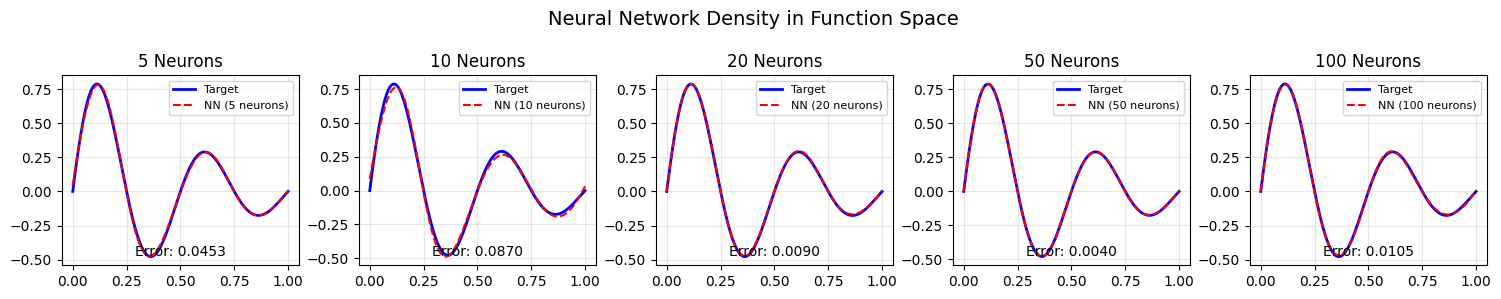

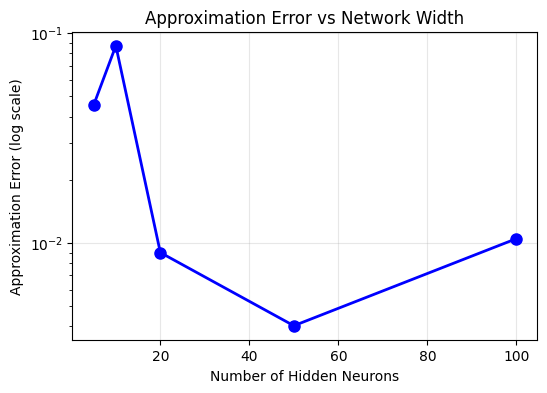


Error reduction: 0.0453 → 0.0105 (4.3x improvement)


In [17]:
# Demonstrate density concept with neural networks
class SimpleNN(nn.Module):
    def __init__(self, hidden_size, activation='relu'):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

def train_approximator(target_func, hidden_size, activation='relu', epochs=5000):
    """Train a neural network to approximate a target function."""
    # Generate training data
    x_train = torch.linspace(0, 1, 100).reshape(-1, 1)
    y_train = torch.tensor([target_func(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)
    
    # Create and train model
    model = SimpleNN(hidden_size, activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    return model, loss.item()

# Test different network sizes
target = lambda x: np.sin(4 * np.pi * x) * np.exp(-2 * x)
hidden_sizes = [5, 10, 20, 50, 100]

fig, axes = plt.subplots(1, len(hidden_sizes), figsize=(15, 3))
x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
x_test_np = x_test.numpy().flatten()
y_true = np.array([target(x) for x in x_test_np])

errors = []
for i, h_size in enumerate(hidden_sizes):
    model, final_loss = train_approximator(target, h_size, activation='tanh')
    
    with torch.no_grad():
        y_pred = model(x_test).numpy().flatten()
    
    axes[i].plot(x_test_np, y_true, 'b-', linewidth=2, label='Target')
    axes[i].plot(x_test_np, y_pred, 'r--', linewidth=1.5, label=f'NN ({h_size} neurons)')
    axes[i].set_title(f'{h_size} Neurons')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)
    
    error = np.max(np.abs(y_true - y_pred))
    errors.append(error)
    axes[i].text(0.5, 0.05, f'Error: {error:.4f}',
                transform=axes[i].transAxes, ha='center')

plt.suptitle('Neural Network Density in Function Space', fontsize=14)
plt.tight_layout()
plt.show()

# Plot error vs network size
plt.figure(figsize=(6, 4))
plt.semilogy(hidden_sizes, errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Approximation Error (log scale)')
plt.title('Approximation Error vs Network Width')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nError reduction: {errors[0]:.4f} → {errors[-1]:.4f} ({errors[0]/errors[-1]:.1f}x improvement)")

## Sobolev Spaces: Approximating Derivatives

For PDE solutions, we need to approximate not just functions but also their derivatives.

**Sobolev space** $H^k([a,b])$: Functions with $k$ weak derivatives in $L^2$.

Neural networks can approximate functions in Sobolev spaces, meaning they can learn both $f$ and $f'$, $f''$, etc.

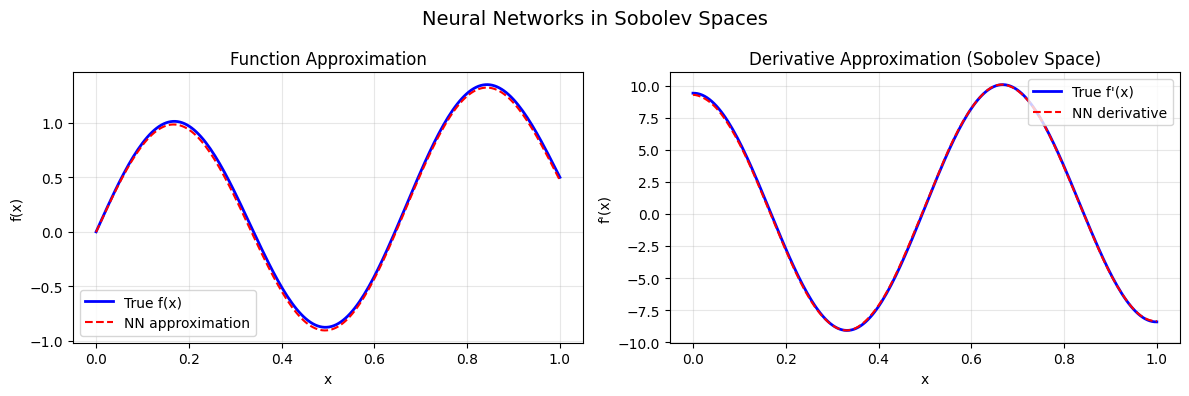

Function error: 0.0425
Derivative error: 0.1859


In [18]:
# Demonstrate derivative approximation
class DerivativeNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

def train_with_derivatives(target_func, target_deriv, hidden_size=50, epochs=10000):
    """Train to approximate both function and derivative."""
    x_train = torch.linspace(0, 1, 50, requires_grad=True).reshape(-1, 1)
    y_train = torch.tensor([target_func(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)
    dy_train = torch.tensor([target_deriv(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)
    
    model = DerivativeNN(hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x_train)
        
        # Compute derivative using autograd
        dy_pred = torch.autograd.grad(y_pred.sum(), x_train, create_graph=True)[0]
        
        # Combined loss for function and derivative
        loss_f = torch.mean((y_pred - y_train)**2)
        loss_df = torch.mean((dy_pred - dy_train)**2)
        loss = loss_f + 0.1 * loss_df  # Weight derivative loss
        
        loss.backward()
        optimizer.step()
    
    return model

# Test function and its derivative
test_func = lambda x: np.sin(3 * np.pi * x) + 0.5 * x**2
test_deriv = lambda x: 3 * np.pi * np.cos(3 * np.pi * x) + x

model = train_with_derivatives(test_func, test_deriv)

# Evaluate
x_test = torch.linspace(0, 1, 200, requires_grad=True).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy().flatten()

# Compute derivative predictions
y_test_grad = model(x_test)
dy_pred = torch.autograd.grad(y_test_grad.sum(), x_test)[0].detach().numpy().flatten()

x_test_np = x_test.detach().numpy().flatten()
y_true = np.array([test_func(x) for x in x_test_np])
dy_true = np.array([test_deriv(x) for x in x_test_np])

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Function approximation
ax1.plot(x_test_np, y_true, 'b-', linewidth=2, label='True f(x)')
ax1.plot(x_test_np, y_pred, 'r--', linewidth=1.5, label='NN approximation')
ax1.set_title('Function Approximation')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Derivative approximation
ax2.plot(x_test_np, dy_true, 'b-', linewidth=2, label="True f'(x)")
ax2.plot(x_test_np, dy_pred, 'r--', linewidth=1.5, label='NN derivative')
ax2.set_title('Derivative Approximation (Sobolev Space)')
ax2.set_xlabel('x')
ax2.set_ylabel("f'(x)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Neural Networks in Sobolev Spaces', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Function error: {np.max(np.abs(y_true - y_pred)):.4f}")
print(f"Derivative error: {np.max(np.abs(dy_true - dy_pred)):.4f}")

## Practical Implications for SciML

### 1. Width vs Depth Trade-offs

- **UAT (single layer)**: Requires exponentially many neurons for some functions
- **Deep networks**: Can be exponentially more efficient
- **Approximation rates**: 
  - Single layer: $O(n^{-1/d})$ for $d$-dimensional inputs
  - Deep networks: Can achieve $O(e^{-cn})$ for smooth functions

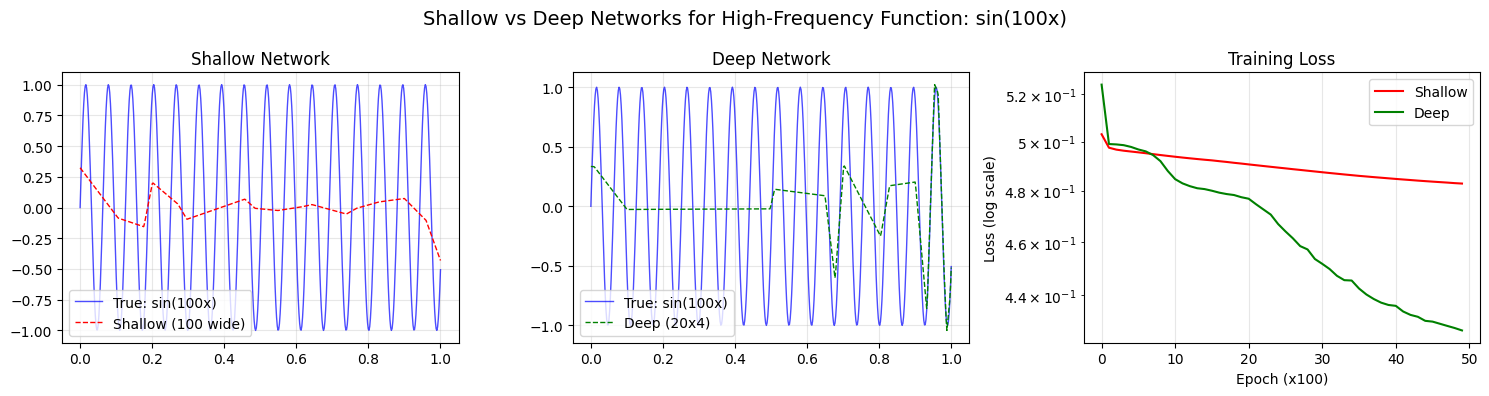

Shallow network parameters: 301
Deep network parameters: 1321
Deep network uses 0.2x fewer parameters

Note: This high-frequency function sin(100x) is challenging for both architectures
but deep networks often show better approximation per parameter.


In [19]:
# Compare shallow vs deep networks
class ShallowNet(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc1 = nn.Linear(1, width)
        self.fc2 = nn.Linear(width, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))

class DeepNet(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        layers = [nn.Linear(1, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers.extend([nn.Linear(width, width), nn.ReLU()])
        layers.append(nn.Linear(width, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# High-frequency function (hard for shallow networks)
# Same function used in mlp.ipynb for consistency
high_freq_func = lambda x: np.sin(100 * x)

# Training data
x_train = torch.linspace(0, 1, 200).reshape(-1, 1)
y_train = torch.tensor([high_freq_func(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)

# Train shallow wide network
shallow_model = ShallowNet(width=100)
optimizer_shallow = torch.optim.Adam(shallow_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

shallow_losses = []
for epoch in range(5000):
    optimizer_shallow.zero_grad()
    loss = criterion(shallow_model(x_train), y_train)
    loss.backward()
    optimizer_shallow.step()
    if epoch % 100 == 0:
        shallow_losses.append(loss.item())

# Train deep narrow network
deep_model = DeepNet(width=20, depth=4)
optimizer_deep = torch.optim.Adam(deep_model.parameters(), lr=0.001)

deep_losses = []
for epoch in range(5000):
    optimizer_deep.zero_grad()
    loss = criterion(deep_model(x_train), y_train)
    loss.backward()
    optimizer_deep.step()
    if epoch % 100 == 0:
        deep_losses.append(loss.item())

# Evaluate
x_test = torch.linspace(0, 1, 500).reshape(-1, 1)
with torch.no_grad():
    y_shallow = shallow_model(x_test).numpy().flatten()
    y_deep = deep_model(x_test).numpy().flatten()

x_test_np = x_test.numpy().flatten()
y_true = np.array([high_freq_func(x) for x in x_test_np])

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Approximations
axes[0].plot(x_test_np, y_true, 'b-', linewidth=1, label='True: sin(100x)', alpha=0.7)
axes[0].plot(x_test_np, y_shallow, 'r--', linewidth=1, label='Shallow (100 wide)')
axes[0].set_title('Shallow Network')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(x_test_np, y_true, 'b-', linewidth=1, label='True: sin(100x)', alpha=0.7)
axes[1].plot(x_test_np, y_deep, 'g--', linewidth=1, label='Deep (20x4)')
axes[1].set_title('Deep Network')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Training curves
axes[2].semilogy(shallow_losses, 'r-', label='Shallow')
axes[2].semilogy(deep_losses, 'g-', label='Deep')
axes[2].set_xlabel('Epoch (x100)')
axes[2].set_ylabel('Loss (log scale)')
axes[2].set_title('Training Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Shallow vs Deep Networks for High-Frequency Function: sin(100x)', fontsize=14)
plt.tight_layout()
plt.show()

# Count parameters
shallow_params = sum(p.numel() for p in shallow_model.parameters())
deep_params = sum(p.numel() for p in deep_model.parameters())

print(f"Shallow network parameters: {shallow_params}")
print(f"Deep network parameters: {deep_params}")
print(f"Deep network uses {shallow_params/deep_params:.1f}x fewer parameters")
print(f"\nNote: This high-frequency function sin(100x) is challenging for both architectures")
print(f"but deep networks often show better approximation per parameter.")